In [879]:
# Author | Sumit Rana

# importing libraries
import sklearn
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn

import matplotlib.pyplot as plt

## Step 1 : Eye-Balling and Understanding Data

In [880]:
data = pd.read_csv("./day.csv")

In [881]:
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [882]:
data.shape

(730, 16)

In [883]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [884]:
# Distribution of dataset , numeric variables
data.describe(percentiles=[0.20,0.35,0.50,0.75,0.90])

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
20%    146.800000    1.000000    0.000000    3.000000    0.000000    1.000000   
35%    256.150000    2.000000    0.000000    5.000000    0.000000    2.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
90%    657.100000    4.000000    1.000000   11.000000    0.000000    6.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
20%      0.000000    1.000000   12.942322   15.554880   49.975000    8.388467   
35%      1.000000    1.000000   16.268470   19.642785   56.833300   10.250179   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
90%      1.000000    2.000000   29.998347   33.908210   81.762500   19.833997   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
20%     245.800000  2208.600000  2653.800000  
35%     472.450000  3130.300000  3821.500000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
90%    1872.000000  5895.400000  7293.800000  
max    3410.000000  6946.000000  8714.000000

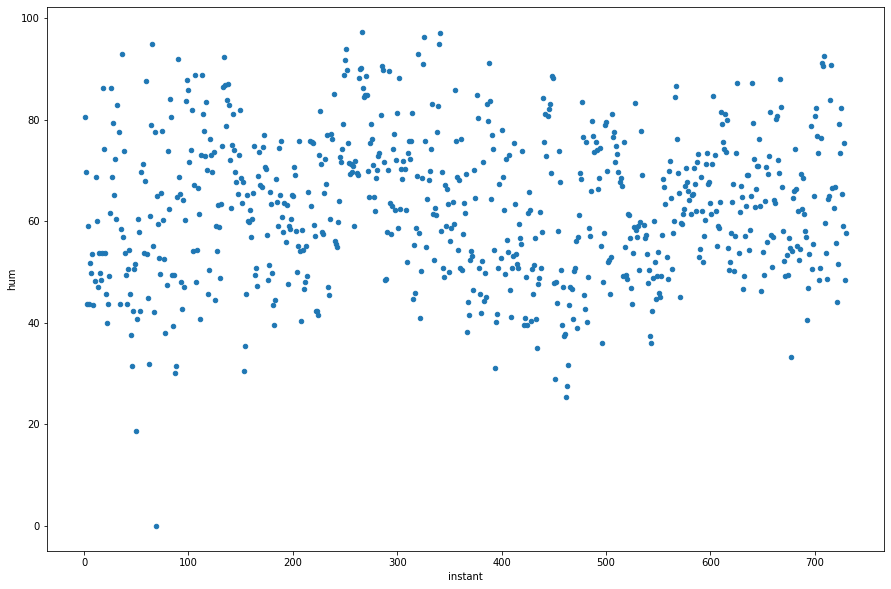

In [885]:
# plotting humidity distribution

data.plot.scatter(x="instant",y="hum",figsize=(15,10))

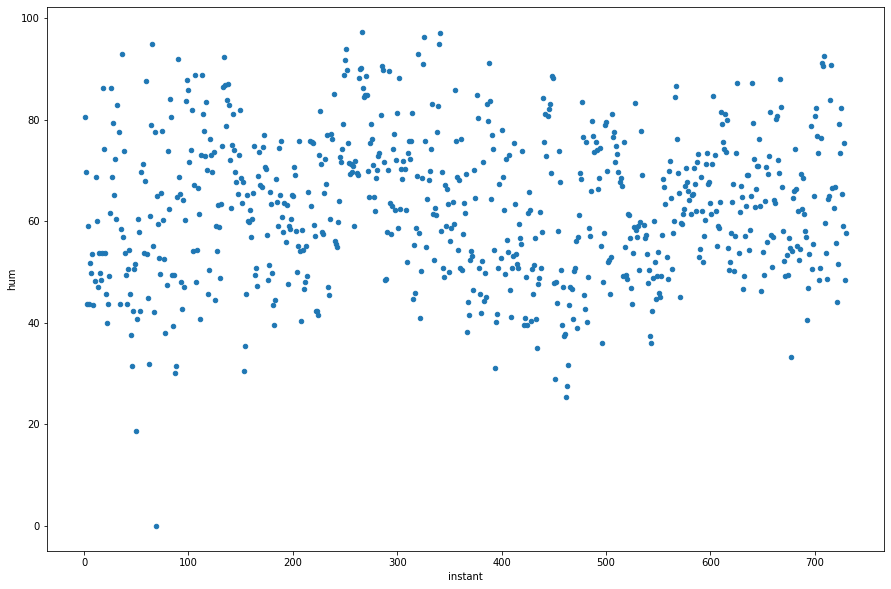

In [886]:
# plotting windspeed

data.plot.scatter(x="instant",y="hum",figsize=(15,10))

In [887]:
# Utility functions

def create_heatmap(matrix,size = (20,15)):
    fig,ax = plt.subplots(figsize=size)
    seaborn.heatmap(matrix, ax=ax,annot=True,cmap="Greens")
    return 200

200

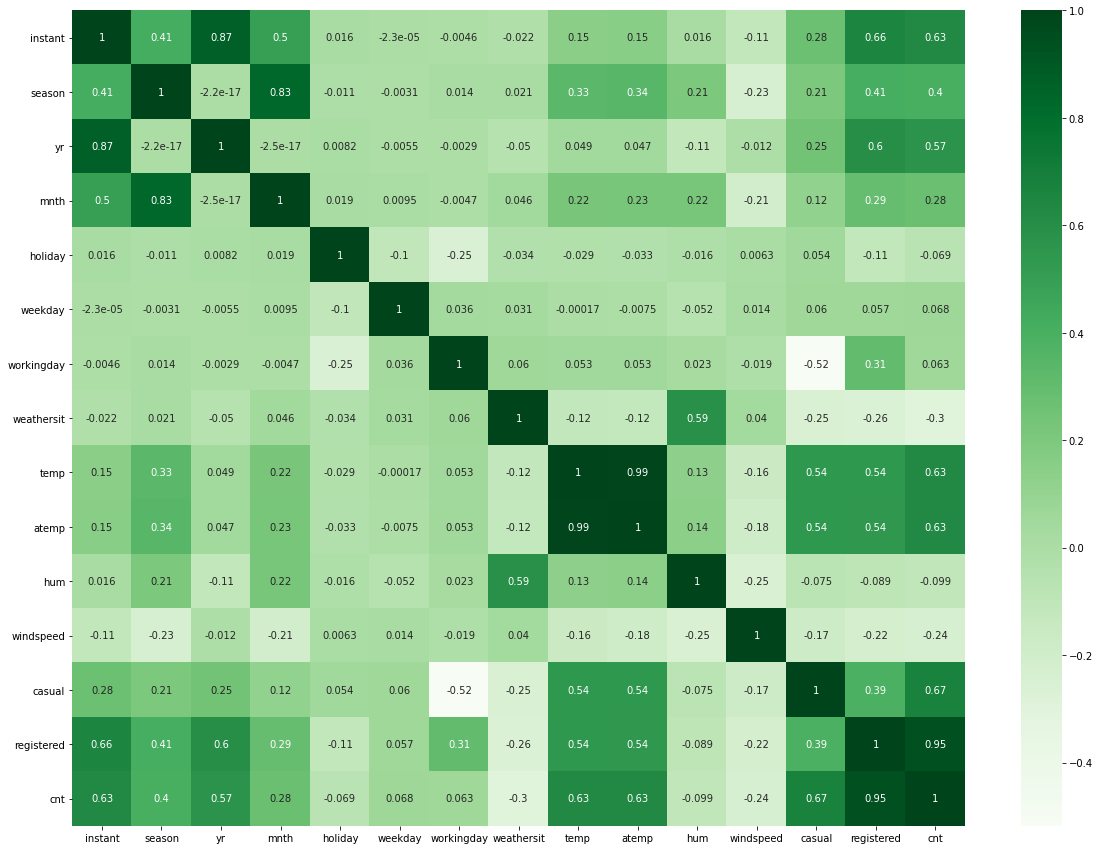

In [888]:
# Correlation between variables

create_heatmap(data.corr())

In [889]:
data.index

RangeIndex(start=0, stop=730, step=1)

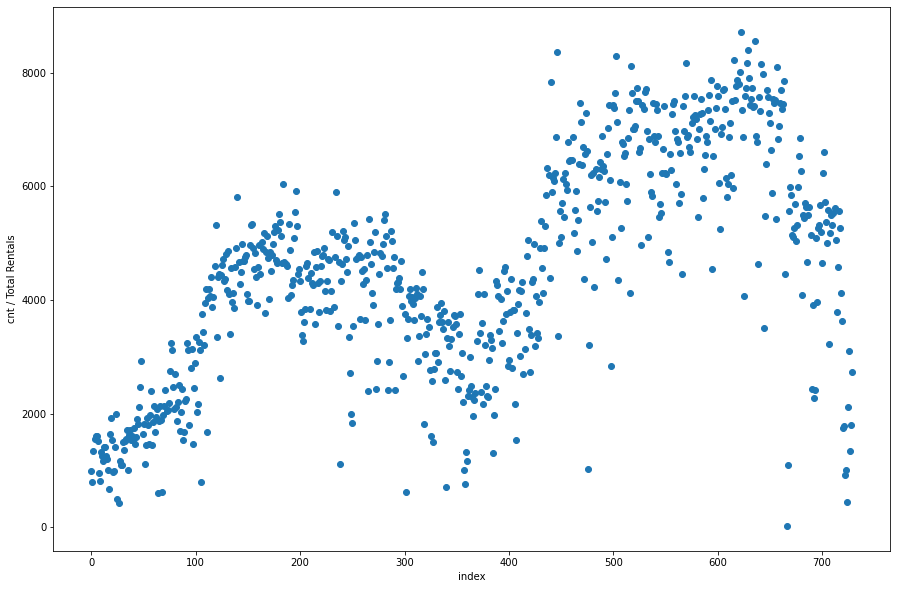

In [890]:
# plotting independent variables

fig,ax = plt.subplots(figsize=(15,10))
plt.scatter(x=data.index,y=data.cnt)
plt.xlabel("index")
plt.ylabel("cnt / Total Rentals")
plt.show()

## Step 2: Cleaning and Standardizing data

In [891]:
data['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [892]:
data['weathersit'].value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [893]:
# Some columns are categorical values
# mapping categorical numeric value to string 

# first mapping categorical variables to string for proper vocablary
# to create a readable dataset

data[['weathersit']] = data[['weathersit']].apply(lambda x: x.map({1: 'Clear',
                                            2: 'Mist and Cloudy',
                                            3: 'Light Rain',
                                            4: 'Heavy Rain'
                                           }))

data[['season']] = data[['season']].apply(lambda x:x.map({
                                            1: 'spring',
                                            2: 'summer',
                                            3: 'fall',
                                            4: 'winter'
                                        }))

In [894]:
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018  spring   0     1        0        6           0   
1        2  02-01-2018  spring   0     1        0        0           0   
2        3  03-01-2018  spring   0     1        0        1           1   
3        4  04-01-2018  spring   0     1        0        2           1   
4        5  05-01-2018  spring   0     1        0        3           1   

        weathersit       temp     atemp      hum  windspeed  casual  \
0  Mist and Cloudy  14.110847  18.18125  80.5833  10.749882     331   
1  Mist and Cloudy  14.902598  17.68695  69.6087  16.652113     131   
2            Clear   8.050924   9.47025  43.7273  16.636703     120   
3            Clear   8.200000  10.60610  59.0435  10.739832     108   
4            Clear   9.305237  11.46350  43.6957  12.522300      82   

   registered   cnt  
0         654   985  
1         670   801  
2        1229  1349  
3        1454  1562  
4        1518  1600

In [895]:
# Encoding 'season'
season_ohe = OneHotEncoder()
encoding = season_ohe.fit_transform(data[['season']])

temp = pd.DataFrame(encoding.toarray(), columns=season_ohe.categories_)

# dropping a column
temp = temp.drop('winter',axis=1)

# concatinating to main dataset
data = pd.concat([data,temp],axis=1)


In [896]:
# Encoding 'weathersit'
weathersit_ohe = OneHotEncoder()
encoding = weathersit_ohe.fit_transform(data[['weathersit']])
temp = pd.DataFrame(encoding.toarray(), columns=weathersit_ohe.categories_)

# dropping a column
temp = temp.drop('Clear',axis=1)

# concatinating to main dataset
data = pd.concat([data,temp],axis=1)


In [897]:
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018  spring   0     1        0        6           0   
1        2  02-01-2018  spring   0     1        0        0           0   
2        3  03-01-2018  spring   0     1        0        1           1   
3        4  04-01-2018  spring   0     1        0        2           1   
4        5  05-01-2018  spring   0     1        0        3           1   

        weathersit       temp  ...      hum  windspeed  casual  registered  \
0  Mist and Cloudy  14.110847  ...  80.5833  10.749882     331         654   
1  Mist and Cloudy  14.902598  ...  69.6087  16.652113     131         670   
2            Clear   8.050924  ...  43.7273  16.636703     120        1229   
3            Clear   8.200000  ...  59.0435  10.739832     108        1454   
4            Clear   9.305237  ...  43.6957  12.522300      82        1518   

    cnt  (fall,)  (spring,)  (summer,)  (Light Rain,)  (Mist and Cloudy,)  
0   985      0.0        1.0        0.0            0.0                 1.0  
1   801      0.0        1.0        0.0            0.0                 1.0  
2  1349      0.0        1.0        0.0            0.0                 0.0  
3  1562      0.0        1.0        0.0            0.0                 0.0  
4  1600      0.0        1.0        0.0            0.0                 0.0  

[5 rows x 21 columns]

200

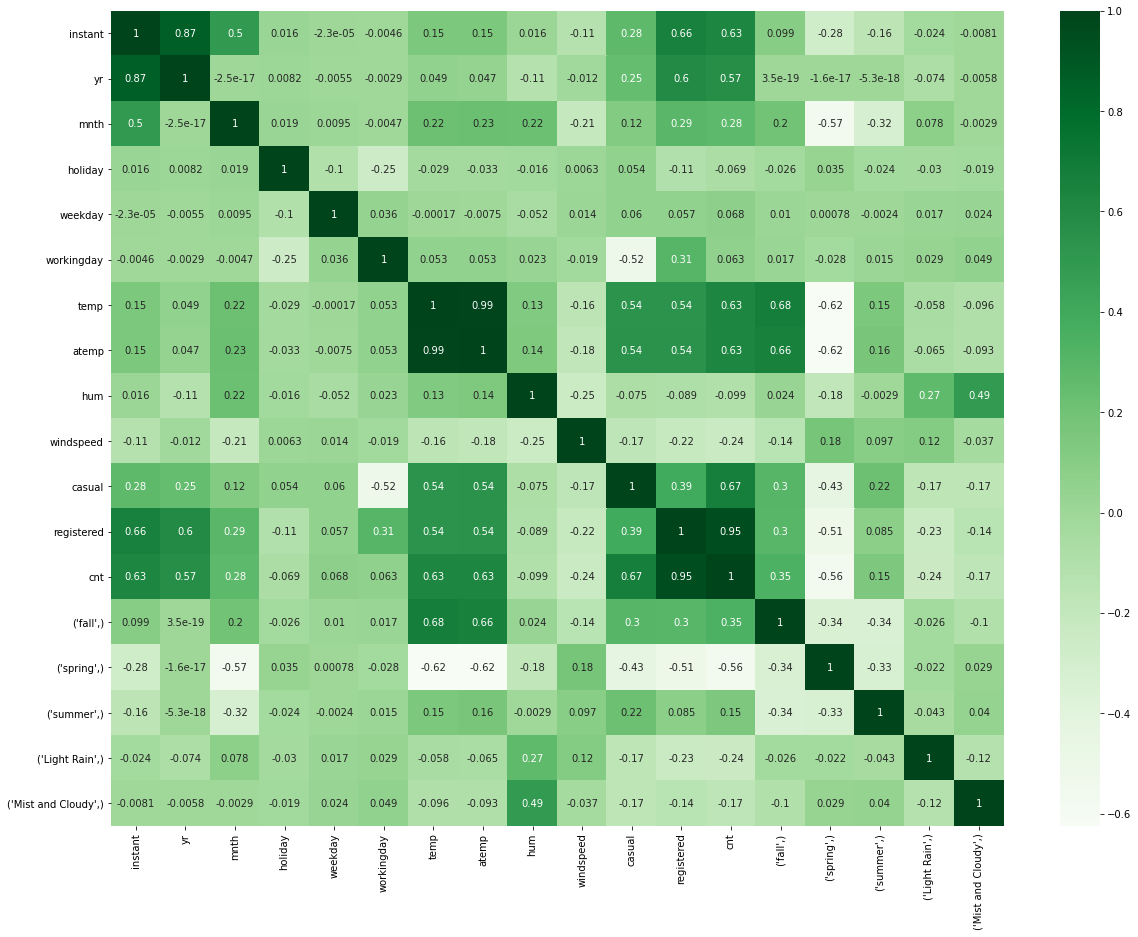

In [898]:
# Correlation on dataset
create_heatmap(data.corr(),size=(20,15))

## Step 3: Preparing data for modelling

### Removing Variables
    -'instant' is essentially the index for records , so can be removed
    -'dteday' is not required, as we are considering months , weeks and years as derived metrices, so can be removed , as we are using other derived variables so the column can be dropped to remove multicollinearity.
    
    - 'season' and 'weathersit' are categorical values and are encoded via one-hot encoding , so original columns can be dropped
     - 'casual' and 'registered' are a subset of the target variables, so are actually dependent so cannot be used in the model else will overfit the model.
    
    

In [899]:
# Removing non-numeric , unwanted variables for modelling

# unwanted_columns = ['instant','dteday','season','weathersit','casual','registered','atemp']
unwanted_columns = ['instant','dteday','season','weathersit','casual','registered']
data = data.drop(unwanted_columns,axis=1)

In [900]:
# Calculating VIF value of independent variables

def calculate_vif():
    columns = list(data.columns)
    columns.remove('cnt')

    independent_columns = columns
    print(independent_columns)

    independent_variable_df = data[independent_columns]

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = independent_variable_df.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(independent_variable_df.values, i)
                              for i in range(len(independent_variable_df.columns))]
    
    return vif_data

In [901]:
vif_data = calculate_vif()
vif_data

['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', ('fall',), ('spring',), ('summer',), ('Light Rain',), ('Mist and Cloudy',)]


feature         VIF
0                   yr    2.019926
1                 mnth   11.610190
2              holiday    1.113960
3              weekday    3.189837
4           workingday    3.320156
5                 temp  575.883055
6                atemp  603.109453
7                  hum   28.635246
8            windspeed    6.870077
9              (fall,)    4.861166
10           (spring,)    4.117659
11           (summer,)    4.385576
12       (Light Rain,)    1.286767
13  (Mist and Cloudy,)    2.279219

## Removing more columns
    - 'atemp' and 'temp' are independent variables but have high correlation of 0.99 , so any one variable can be dropped. These variables shows symptoms of multicollinearity.

In [902]:
# Removing non-numeric , unwanted variables for modelling

unwanted_columns = ['atemp','hum']
data = data.drop(unwanted_columns,axis=1)

vif_data = calculate_vif()
vif_data

['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'windspeed', ('fall',), ('spring',), ('summer',), ('Light Rain',), ('Mist and Cloudy',)]


feature        VIF
0                   yr   2.010304
1                 mnth   8.033596
2              holiday   1.112312
3              weekday   3.189024
4           workingday   3.304183
5                 temp  20.329322
6            windspeed   6.786056
7              (fall,)   4.764948
8            (spring,)   2.918423
9            (summer,)   4.102278
10       (Light Rain,)   1.086714
11  (Mist and Cloudy,)   1.546992

### Comments
* Recursive Feature Elimination can also be applied on the dataset, but it is not required as we have already eliminated columns showing multicollinearity symptoms.

200

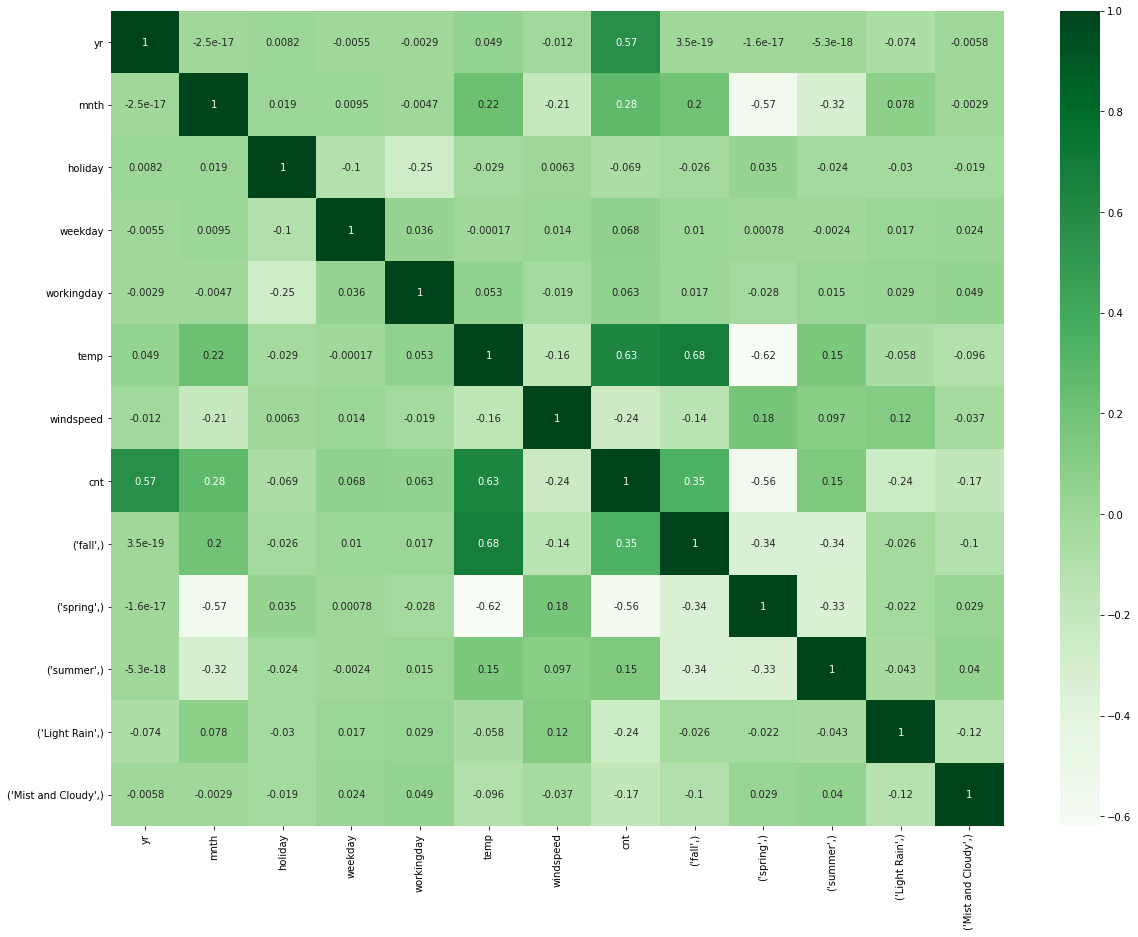

In [903]:
# correlation after dropping variables

create_heatmap(data.corr(),size=(20,15))

In [904]:
# data after dropping insignificant columns

data.head()

yr  mnth  holiday  weekday  workingday       temp  windspeed   cnt  \
0   0     1        0        6           0  14.110847  10.749882   985   
1   0     1        0        0           0  14.902598  16.652113   801   
2   0     1        0        1           1   8.050924  16.636703  1349   
3   0     1        0        2           1   8.200000  10.739832  1562   
4   0     1        0        3           1   9.305237  12.522300  1600   

   (fall,)  (spring,)  (summer,)  (Light Rain,)  (Mist and Cloudy,)  
0      0.0        1.0        0.0            0.0                 1.0  
1      0.0        1.0        0.0            0.0                 1.0  
2      0.0        1.0        0.0            0.0                 0.0  
3      0.0        1.0        0.0            0.0                 0.0  
4      0.0        1.0        0.0            0.0                 0.0

In [905]:
# plots to visualize correlation
# with large number of independent variables this visualization is not very effective and helpful

seaborn.pairplot(data)

### Comments
- Data Scaling is not required here as such in linear model, as there not much outliers in dataset.
- Also with the dataset size the scale of data is not impacting the training time.

### Preparing dataset for training and testing

In [906]:
columns = list(data.columns)

# Predictor variables
Y = data['cnt']

# Target Variable
columns.remove('cnt')
X = data[columns]

print("Predictor Variables :{}".format(columns))
train_data, test_data= train_test_split(data,train_size=0.75,random_state=100)

# creating train and test sets
train_x = train_data[columns]
train_y = train_data['cnt']

test_x = test_data[columns]
test_y = test_data['cnt']

Predictor Variables :['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'windspeed', ('fall',), ('spring',), ('summer',), ('Light Rain',), ('Mist and Cloudy',)]


In [907]:
print("Training data shape: {}, Testing data shape: {}".format(train_x.shape,test_x.shape))

Training data shape: (547, 12), Testing data shape: (183, 12)


In [908]:
train_x.shape, train_y.shape,test_x.shape, test_y.shape

((547, 12), (547,), (183, 12), (183,))

## Step 4: Creating Model

In [909]:
model = LinearRegression()

In [910]:
train_x

yr  mnth  holiday  weekday  workingday       temp  windspeed  (fall,)  \
311   0    11        0        2           1  16.741653   4.625513      0.0   
523   1     6        0        5           1  26.615847  11.750661      0.0   
381   1     1        0        2           1  15.294763  23.391710      0.0   
413   1     2        0        6           0  14.213347  12.792243      0.0   
253   0     9        0        0           0  26.786653   7.708618      1.0   
..   ..   ...      ...      ...         ...        ...        ...      ...   
578   1     8        0        4           1  30.852500   8.666718      1.0   
53    0     2        0        3           1   9.091299   6.305571      0.0   
350   0    12        0        6           0  10.591653  16.292189      0.0   
79    0     3        0        1           1  17.647835  19.348461      0.0   
520   1     6        0        2           1  22.174153  14.041525      0.0   

     (spring,)  (summer,)  (Light Rain,)  (Mist and Cloudy,)  
311        0.0        0.0            0.0                 0.0  
523        0.0        1.0            0.0                 0.0  
381        1.0        0.0            0.0                 1.0  
413        1.0        0.0            0.0                 0.0  
253        0.0        0.0            0.0                 0.0  
..         ...        ...            ...                 ...  
578        0.0        0.0            0.0                 0.0  
53         1.0        0.0            0.0                 0.0  
350        0.0        0.0            0.0                 1.0  
79         0.0        1.0            0.0                 1.0  
520        0.0        1.0            0.0                 1.0  

[547 rows x 12 columns]

In [911]:
test_y[:5]

184    6043
535    6211
299    2659
221    4780
152    4968
Name: cnt, dtype: int64

In [912]:
# fitting model
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [913]:
# model coefficients
model.coef_

array([ 2027.6109982 ,    -6.66248233,  -706.97639104,    77.22837947,
         168.10882876,   125.76204597,   -42.03347054,  -758.75170394,
       -1500.09004324,  -415.83729728, -2484.88101099,  -668.42834016])

In [914]:
model.intercept_

2157.867186723996

### Evaluating training dataset

In [915]:
# inferencing model on training dataset

train_ypredicted = model.predict(train_x)

In [916]:
# Residual Analysis on training data

training_residuals = train_y-train_ypredicted

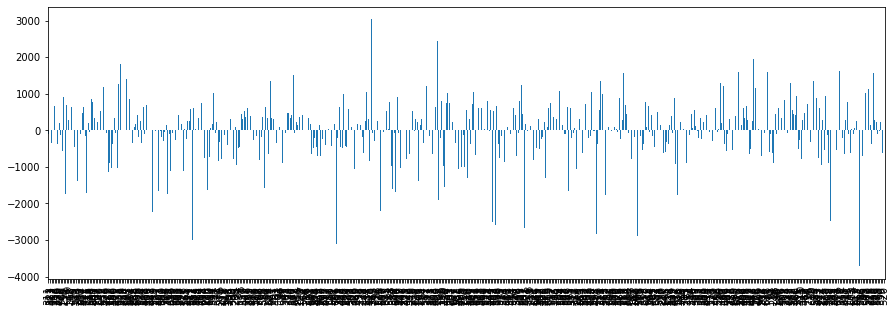

In [917]:
training_residuals.plot.bar(figsize=(15,5))

/home/sam/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


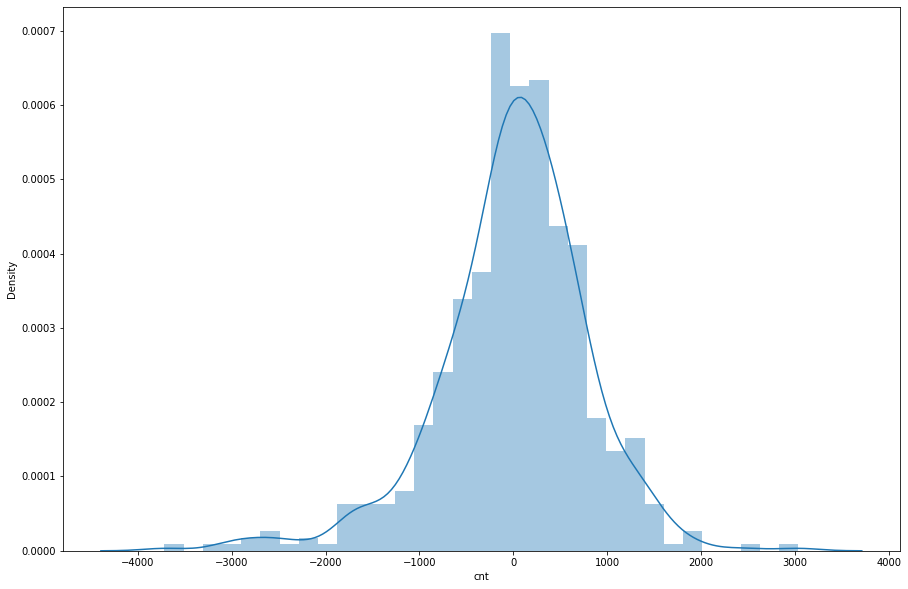

In [918]:
fig,ax =  plt.subplots(figsize=(15,10))
seaborn.distplot(training_residuals,ax=ax)

In [919]:
# r2_score on training data

accuracy = r2_score(train_y,train_ypredicted)
print("Training Accuracy : {}%".format(round(accuracy*100,3)))

Training Accuracy : 83.388%


In [920]:
rmse = mean_squared_error(y_true=train_y,y_pred=train_ypredicted,squared=False)
rmse

796.4102112547703

## Step 5: Model Evaluation 

In [921]:
# Making predictions on test set on model
test_ypredicted = model.predict(test_x)

In [922]:
# Residual Analysis on training data

testing_residuals = test_y-test_ypredicted

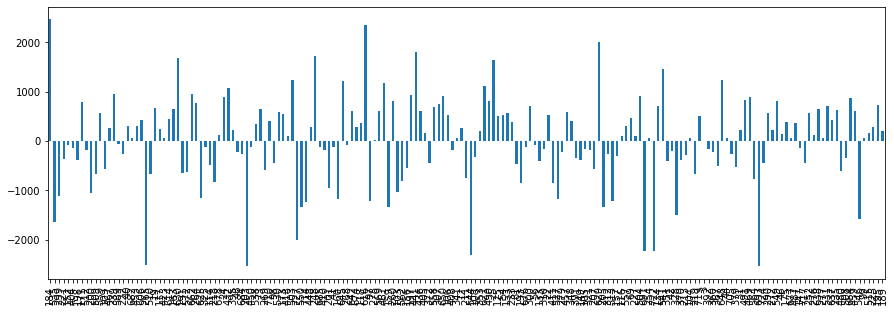

In [923]:
testing_residuals.plot.bar(figsize=(15,5))

/home/sam/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


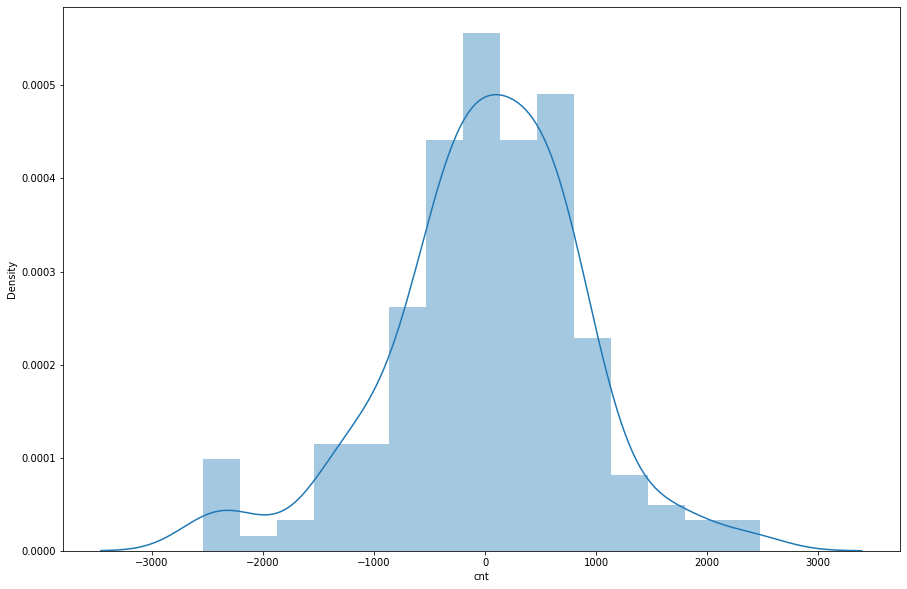

In [924]:
fig,ax =  plt.subplots(figsize=(15,10))
seaborn.distplot(testing_residuals,ax=ax)

In [925]:
test_y[115:120], test_ypredicted[115:120]

(391    3456
 149    4098
 105     795
 321    3392
 207    4656
 Name: cnt, dtype: int64,
 array([3790.91831866, 4490.6518375 ,  955.55126475, 3577.87272273,
        5231.6847818 ]))

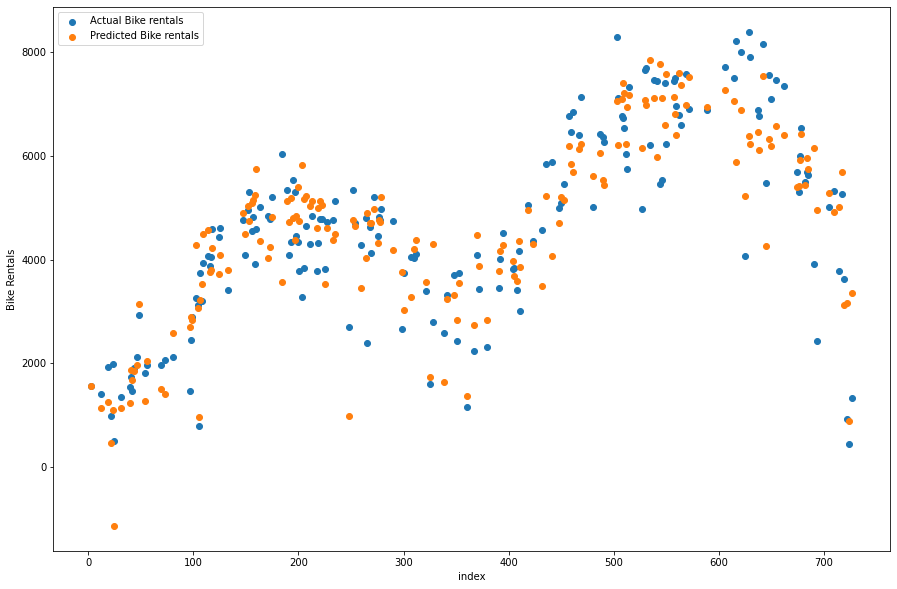

In [926]:
# plotting Regression line with model

fig,ax = plt.subplots(figsize=(15,10))
plt.scatter(x=test_x.index,y=test_y, label="Actual Bike rentals")
plt.xlabel("index")
plt.ylabel("Bike Rentals")

plt.scatter(x=test_x.index,y=test_ypredicted, label="Predicted Bike rentals")
plt.legend()
plt.show()


In [927]:
# r2_score on training data

accuracy = r2_score(test_y,test_ypredicted)
print("Testing Accuracy : {}%".format(round(accuracy*100,3)))

Testing Accuracy : 78.483%


In [928]:
rmse = mean_squared_error(y_true=test_y,y_pred=test_ypredicted,squared=False)
rmse

867.6363511862338

### Comments:
    - random_state as 42 in splitting training and test data , gave a little over fit data
    - using random_state as 100 in splitting dataset gave more generalised model
    -'hum' and 'month' can also be removed cause of high VIF value , but removing them didn't impacted the model accuracy and they show high correlation with the target variable.

In [929]:
# R2 Score
y_test = test_y
y_pred = test_ypredicted


from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7848299027487168